In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

#plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
import sweetviz

#preprocessing
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
import pickle

In [3]:
# read the data
df = pd.read_csv('BMW_SCORE.csv')
og = df.copy()
df.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,county,state,lat,long
0,7112174332,treasure coast,2013,bmw,m3 convertible 2d,good,8 cylinders,gas,41925.0,clean,other,WBSDX9C51DE785431,rwd,NaN,convertible,black,NaN,fl,33.7865,-84.4454
1,7112165475,treasure coast,2006,bmw,325ci convertible,excellent,6 cylinders,gas,97000.0,clean,automatic,NaN,rwd,full-size,convertible,blue,NaN,fl,26.8057,-80.0797
2,7112164637,treasure coast,2014,bmw,z4 sdrive28i roadster 2d,good,NaN,gas,40830.0,clean,automatic,WBALL5C59EP556585,rwd,NaN,convertible,grey,NaN,fl,33.7865,-84.4454
3,7121238635,north jersey,2015,bmw,650i / alpina b6,NaN,NaN,gas,52610.0,clean,automatic,WBA6B4C59FD760641,NaN,compact,sedan,silver,NaN,nj,40.8765,-74.0721
4,7112119826,treasure coast,2016,bmw,4-series,excellent,6 cylinders,gas,37975.0,clean,manual,WBA3R5C55GK371013,4wd,mid-size,coupe,black,NaN,fl,28.4661,-81.3964


In [4]:
#Reindexing to keep price at last
df= df.reindex(columns=['id', 'region', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
        'county', 'state', 'lat', 'long'])

In [5]:
df.shape

(1000, 20)

In [6]:
df.describe()

,id,year,odometer,county,lat,long
count,1.000000e+03,1000.00000,954.000000,0.0,941.000000,941.000000
mean,7.116569e+09,2010.84600,81706.399371,NaN,38.550926,-90.949150
std,4.384051e+06,5.33955,42982.833697,NaN,4.748182,18.786674
min,7.105620e+09,1971.00000,0.000000,NaN,-30.451800,-147.714000
25%,7.113757e+09,2008.00000,49845.250000,NaN,35.551300,-106.682000
50%,7.117614e+09,2012.00000,79301.000000,NaN,39.433100,-84.411800
75%,7.120436e+09,2015.00000,109932.500000,NaN,41.512100,-73.976800
max,7.121563e+09,2020.00000,263050.000000,NaN,64.822800,-69.528400


## Data Preprocessing

Missing Values

<AxesSubplot:>

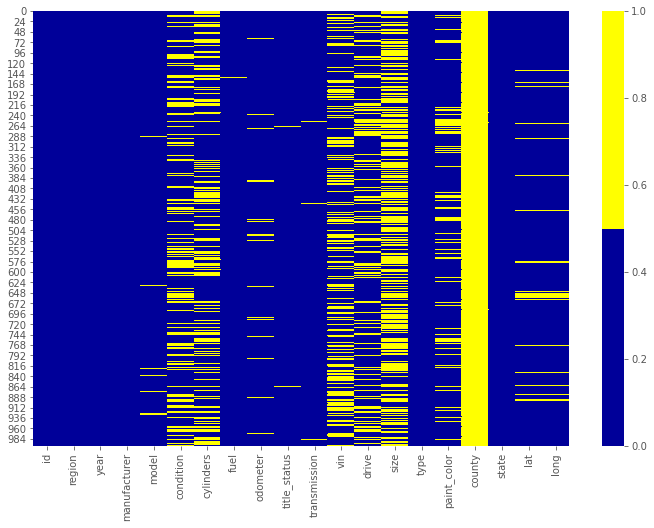

In [7]:
colours = ['#000099','#ffff00']
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

#Missing Values

In [8]:
df.notnull().sum().sum()

16888

In [9]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0%
region - 0%
year - 0%
manufacturer - 0%
model - 1%
condition - 30%
cylinders - 32%
fuel - 0%
odometer - 5%
title_status - 0%
transmission - 0%
vin - 35%
drive - 25%
size - 56%
type - 0%
paint_color - 13%
county - 100%
state - 0%
lat - 6%
long - 6%


In [10]:
#dropping irrelevant columns
drop_columns = ['manufacturer','vin','county']
cdf = df.drop(columns=drop_columns)

In [11]:
cdf.head()

,id,region,year,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,7112174332,treasure coast,2013,m3 convertible 2d,good,8 cylinders,gas,41925.0,clean,other,rwd,NaN,convertible,black,fl,33.7865,-84.4454
1,7112165475,treasure coast,2006,325ci convertible,excellent,6 cylinders,gas,97000.0,clean,automatic,rwd,full-size,convertible,blue,fl,26.8057,-80.0797
2,7112164637,treasure coast,2014,z4 sdrive28i roadster 2d,good,NaN,gas,40830.0,clean,automatic,rwd,NaN,convertible,grey,fl,33.7865,-84.4454
3,7121238635,north jersey,2015,650i / alpina b6,NaN,NaN,gas,52610.0,clean,automatic,NaN,compact,sedan,silver,nj,40.8765,-74.0721
4,7112119826,treasure coast,2016,4-series,excellent,6 cylinders,gas,37975.0,clean,manual,4wd,mid-size,coupe,black,fl,28.4661,-81.3964


In [12]:
cdf.isnull().sum().sum()

1758

# Taking care of missing values

In [13]:
#Filling all the null values
for i in cdf.drop(['paint_color','size'], axis = 1).columns:
    if cdf[i].dtypes =='float':
        cdf[i] = cdf[i].fillna(cdf[i].median())
    if cdf[i].dtype=='object':
        cdf[i]=cdf[i].fillna(cdf[i].mode()[0])
cdf['paint_color'] = cdf['paint_color'].fillna('Unknown')
cdf['size'] = cdf['size'].fillna('Unknown')
cleaned = cdf.copy()
cleaned.to_csv('cleaned_score.csv')

In [14]:
cdf.head()

,id,region,year,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,7112174332,treasure coast,2013,m3 convertible 2d,good,8 cylinders,gas,41925.0,clean,other,rwd,Unknown,convertible,black,fl,33.7865,-84.4454
1,7112165475,treasure coast,2006,325ci convertible,excellent,6 cylinders,gas,97000.0,clean,automatic,rwd,full-size,convertible,blue,fl,26.8057,-80.0797
2,7112164637,treasure coast,2014,z4 sdrive28i roadster 2d,good,6 cylinders,gas,40830.0,clean,automatic,rwd,Unknown,convertible,grey,fl,33.7865,-84.4454
3,7121238635,north jersey,2015,650i / alpina b6,excellent,6 cylinders,gas,52610.0,clean,automatic,rwd,compact,sedan,silver,nj,40.8765,-74.0721
4,7112119826,treasure coast,2016,4-series,excellent,6 cylinders,gas,37975.0,clean,manual,4wd,mid-size,coupe,black,fl,28.4661,-81.3964


In [15]:
cdf.shape

(1000, 17)

In [16]:
cleaned.head()

,id,region,year,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,7112174332,treasure coast,2013,m3 convertible 2d,good,8 cylinders,gas,41925.0,clean,other,rwd,Unknown,convertible,black,fl,33.7865,-84.4454
1,7112165475,treasure coast,2006,325ci convertible,excellent,6 cylinders,gas,97000.0,clean,automatic,rwd,full-size,convertible,blue,fl,26.8057,-80.0797
2,7112164637,treasure coast,2014,z4 sdrive28i roadster 2d,good,6 cylinders,gas,40830.0,clean,automatic,rwd,Unknown,convertible,grey,fl,33.7865,-84.4454
3,7121238635,north jersey,2015,650i / alpina b6,excellent,6 cylinders,gas,52610.0,clean,automatic,rwd,compact,sedan,silver,nj,40.8765,-74.0721
4,7112119826,treasure coast,2016,4-series,excellent,6 cylinders,gas,37975.0,clean,manual,4wd,mid-size,coupe,black,fl,28.4661,-81.3964


In [17]:
cdf.isnull().sum()

id              0
region          0
year            0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
lat             0
long            0
dtype: int64

In [18]:
#Creating separate lists of colums with numeric and category vars
num_cols=['year','odometer','lat','long']
cat_cols=['region','model','condition','cylinders','fuel','title_status','transmission',
          'drive','size','type','paint_color','state']

In [19]:
#Encoding Categorical Variables
for col in cat_cols:
    if col in cdf.columns:
        le = LabelEncoder()
        le.fit(list(cdf[col].astype(str).values))
        cdf[col] = le.transform(list(cdf[col].astype(str).values))

In [20]:
cdf.shape

(1000, 17)

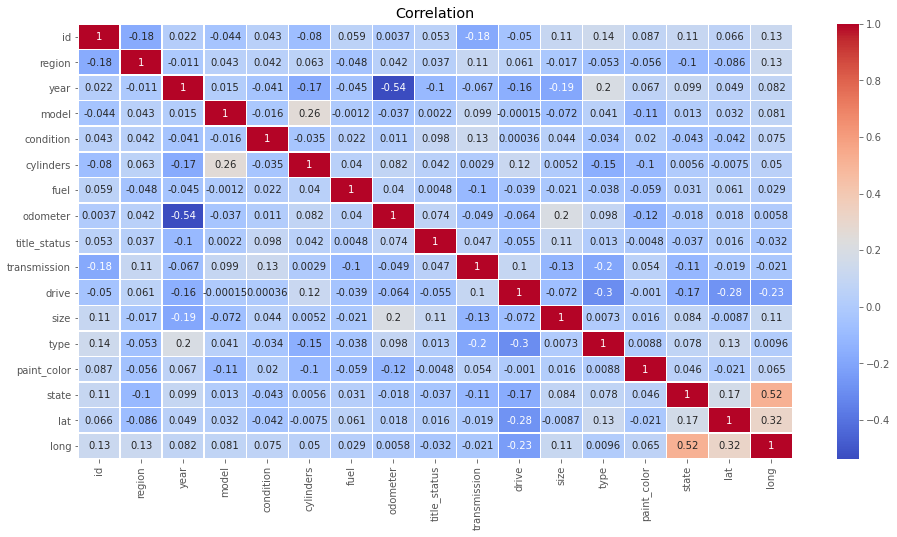

In [21]:
plt.figure(figsize = (16,8))
sns_plot = sns.heatmap(cdf.corr(), annot = True, cmap="coolwarm",linewidth=.5).set_title("Correlation")

In [22]:
print("Shape before process=",og.shape)
print("Shape After process=",cdf.shape)
diff=og.shape[0]-cdf.shape[0]
print("Total {} rows and {} cols removed".format(diff,og.shape[1]-cdf.shape[1]))

Shape before process= (1000, 20)
Shape After process= (1000, 17)
Total 0 rows and 3 cols removed


In [23]:
df = cdf.copy()

In [24]:
display(cdf.iloc[682])

id              7.119073e+09
region          4.800000e+01
year            2.011000e+03
model           8.300000e+01
condition       3.000000e+00
cylinders       3.000000e+00
fuel            2.000000e+00
odometer        8.200000e+04
title_status    0.000000e+00
transmission    0.000000e+00
drive           0.000000e+00
size            3.000000e+00
type            3.000000e+00
paint_color     1.000000e+00
state           2.100000e+01
lat             4.157490e+01
long           -7.359480e+01
Name: 682, dtype: float64

In [25]:
df.tail(5)

,id,region,year,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
995,7121343334,77,2011,83,0,3,2,68500.0,4,0,0,2,3,11,21,43.1099,-75.1628
996,7110333906,99,2012,75,0,3,2,73139.0,0,0,2,1,3,1,2,37.9587,-121.2750
997,7120797699,25,2013,145,0,2,2,87119.0,0,0,0,3,3,11,3,39.7005,-104.8650
998,7110318389,99,2015,230,2,3,1,30696.0,0,2,2,0,2,11,2,33.7792,-84.4118
999,7120031225,47,2016,162,0,3,2,37733.0,0,0,2,0,3,1,26,29.7452,-95.7418


# SCaling

In [26]:
norm = StandardScaler()
df['odometer'] = norm.fit_transform(np.array(df['odometer']).reshape(-1,1))
df['year'] = norm.fit_transform(np.array(df['year']).reshape(-1,1))
df['model'] = norm.fit_transform(np.array(df['model']).reshape(-1,1))
df['state'] = norm.fit_transform(np.array(df['state']).reshape(-1,1))
df['region'] = norm.fit_transform(np.array(df['region']).reshape(-1,1))
df['lat'] = norm.fit_transform(np.array(df['lat']).reshape(-1,1))
df['long'] = norm.fit_transform(np.array(df['long']).reshape(-1,1))

# Creating Test dataframe


In [27]:
df.head()

,id,region,year,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,7112174332,1.146118,0.403607,1.451192,2,4,2,-0.945361,0,2,2,0,0,1,-0.879361,-1.045191,0.334697
1,7112165475,1.146118,-0.908021,-0.876637,0,3,2,0.367086,0,0,2,2,0,2,-0.879361,-2.560048,0.573529
2,7112164637,1.146118,0.590982,1.869678,2,3,2,-0.971455,0,0,2,0,0,6,-0.879361,-1.045191,0.334697
3,7121238635,0.331990,0.778357,0.849618,0,3,2,-0.690735,0,0,2,1,3,10,0.550316,0.493363,0.902183
4,7112119826,1.146118,0.965733,-0.105053,0,3,2,-1.039490,0,1,0,3,1,1,-0.879361,-2.199736,0.501497


In [28]:
X_test = df.drop(['id'], axis = 'columns')

In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        1000 non-null   float64
 1   year          1000 non-null   float64
 2   model         1000 non-null   float64
 3   condition     1000 non-null   int64  
 4   cylinders     1000 non-null   int64  
 5   fuel          1000 non-null   int64  
 6   odometer      1000 non-null   float64
 7   title_status  1000 non-null   int64  
 8   transmission  1000 non-null   int64  
 9   drive         1000 non-null   int64  
 10  size          1000 non-null   int64  
 11  type          1000 non-null   int64  
 12  paint_color   1000 non-null   int64  
 13  state         1000 non-null   float64
 14  lat           1000 non-null   float64
 15  long          1000 non-null   float64
dtypes: float64(7), int64(9)
memory usage: 125.1 KB


In [31]:
#loading model
filename = 'scoring_model.sav'
load_model = pickle.load(open(filename,'rb'))

In [32]:
mod_y_pred = load_model.predict(X_test)

In [33]:
mod_y_pred

array([10.13289129,  8.89646267, 10.21821389, 10.12637915,  9.97038112,
        9.79442629, 10.43709386,  9.73913678,  9.87914099,  8.82249179,
        9.66504971,  8.38708467, 10.29395563,  9.78860994,  9.60778346,
       10.42654294,  8.80824504,  9.27534214,  8.82882923,  9.81197461,
        8.6105549 ,  9.48988227,  9.94306755,  9.26102403,  9.56776341,
       10.34394289,  8.98788622,  8.96479055,  9.42920888,  9.72959598,
        8.52318536,  9.66747409, 10.08604425,  8.6933603 ,  9.81311987,
        9.95834555,  8.18997031,  9.66699543,  9.18122283,  8.82567833,
        8.90341777,  8.78375706,  8.92236124,  8.76436218,  9.9793276 ,
        9.97130429,  9.27509466,  8.88625145,  8.21238049,  9.54952366,
        9.78494362,  9.47541645,  9.43926685,  9.88912424,  8.90341777,
        9.77139147,  9.80309422,  8.23177091,  8.8584055 ,  8.75661911,
        9.91195226, 10.15498269,  8.88661993,  9.42082593,  9.14512624,
        9.208945  , 10.13183512,  9.85363673,  9.01490121,  9.83

In [ ]:
df['price'] = np.exp(mod_y_pred)

In [ ]:
df.to_csv("wo_scored.csv")

In [ ]:
og['price'] = np.exp(mod_y_pred)
og.to_csv('okay.csv')
og.to_html('dataframe.html')

In [ ]:
og.head()

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))